# Dimensionality Reduction in [Bayer and Luetticke (2018)](https://cepr.org/active/publications/discussion_papers/dp.php?dpno=13071)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/HARK/BayerLuetticke?filepath=HARK%2FBayerLuetticke%2FDCT-Copula-Illustration.ipynb)

This companion to the [main notebook](TwoAsset.ipynb) explains in more detail how the authors reduce the dimensionality of their problem

- Based on original slides by Christian Bayer and Ralph Luetticke 
- Original Jupyter notebook by Seungcheol Lee 
- Further edits by Chris Carroll, Tao Wang 


### Preliminaries

In Steady-state Equilibrium (StE) in the model, in any given period, a consumer in state $s$ (which comprises liquid assets $m$, illiquid assets $k$, and human capital $\newcommand{hLev}{h}\hLev$) has two key choices:
1. To adjust ('a') or not adjust ('n') their holdings of illiquid assets $k$
1. Contingent on that choice, decide the level of consumption, yielding consumption functions:
    * $c_n(s)$ - nonadjusters
    * $c_a(s)$ - adjusters

The usual envelope theorem applies here, so marginal value wrt the liquid asset equals marginal utility with respect to consumption:
$[\frac{d v}{d m} = \frac{d u}{d c}]$.
In practice, the authors solve their problem using the marginal value of money $\texttt{Vm} = dv/dm$, but because the marginal utility function is invertible it is trivial to recover $\texttt{c}$ from $(u^{\prime})^{-1}(\texttt{Vm} )$.  The consumption function is therefore computed from the $\texttt{Vm}$ function

In [2]:
# Setup stuff

# This is a jupytext paired notebook that autogenerates a corresponding .py file
# which can be executed from a terminal command line via "ipython [name].py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 
    
# The tools for navigating the filesystem
import sys
import os

# Find pathname to this file:
my_file_path = os.path.dirname(os.path.abspath("TwoAsset.ipynb"))

# Relative directory for pickled code
code_dir = os.path.join(my_file_path, "BayerLuetticke_code/OneAssetCode-HANK") 

sys.path.insert(0, code_dir)
sys.path.insert(0, my_file_path)

In [3]:
# Load precalculated Stationary Equilibrium (StE) object EX3SS

import pickle
os.chdir(code_dir) # Go to the directory with pickled code

EX2SS=pickle.load(open("EX2SS.p", "rb"))

In [4]:
EX2SS.keys()

dict_keys(['par', 'mpar', 'grid', 'Output', 'targets', 'Vm', 'joint_distr', 'Copula', 'c_policy', 'm_policy', 'mutil_c', 'P_H'])

### Dimensions

The imported StE solution to the problem represents the functions at a set of gridpoints of
   * liquid assets ($n_m$ points), illiquid assets ($n_k$), and human capital ($n_h$)
      * In the code these are $\{\texttt{nm,nk,nh}\}$

So even if the grids are fairly sparse for each state variable, the total number of combinations of the idiosyncratic state gridpoints is large: $n = n_m \times n_k \times n_h$.  So, e.g., $\bar{c}$ is a set of size $n$ containing the level of consumption at each possible _combination_ of gridpoints.

In the "real" micro problem, it would almost never happen that a continuous variable like $m$ would end up being exactly equal to one of the prespecified gridpoints. But the functions need to be evaluated at such non-grid points.  This is addressed by linear interpolation.  That is, if, say, the grid had $m_{8} = 40$ and $m_{9} = 50$ then and a consumer ended up with $m = 45$ then the approximation is that $\tilde{c}(45) = 0.5 \bar{c}_{8} + 0.5 \bar{c}_{9}$.


In [5]:
# Show dimensions of the consumer's problem (state space)

print('c is of dimension: ' + str(EX2SS['mutil_c'].shape))


print('Vm is of dimension:' + str(EX2SS['Vm'].shape))

print('For convenience, these are all constructed from the same exogenous grids:')
print(str(len(EX2SS['grid']['m']))+' gridpoints for liquid assets;')
print(str(len(EX2SS['grid']['h']))+' gridpoints for individual productivity.')
print('')
print('Therefore, the joint distribution is of size: ')
print(str(EX2SS['mpar']['nm'])+
    ' * '+str(EX2SS['mpar']['nh'])+
   ' = '+ str(EX2SS['mpar']['nm']*EX2SS['mpar']['nh']))

c is of dimension: (500, 4)
Vm is of dimension:(500, 4)
For convenience, these are all constructed from the same exogenous grids:
500 gridpoints for liquid assets;
4 gridpoints for individual productivity.

Therefore, the joint distribution is of size: 
500 * 4 = 2000


### Dimension Reduction

The authors use different dimensionality reduction methods for the consumer's problem and the distribution across idiosyncratic states

#### Representing the consumer's problem with Basis Functions

The idea is to find an efficient "compressed" representation of our functions (e.g., the consumption function), which BL do using tools originally developed for image compression.  The analogy to image compression is that nearby pixels are likely to have identical or very similar colors, so we need only to find an efficient way to represent how the colors _change_ from one pixel to nearby ones.  Similarly, consumption at a given point $s_{i}$ is likely to be close to consumption point at another point $s_{j}$ that is "close" in the state space (similar wealth, income, etc), so a function that captures that similarity efficiently can preserve most of the information without keeping all of the points.

Like linear interpolation, the [DCT transformation](https://en.wikipedia.org/wiki/Discrete_cosine_transform) is a method of representing a continuous function using a finite set of numbers. It uses a set of independent [basis functions](https://en.wikipedia.org/wiki/Basis_function) to do this.

But it turns out that some of those basis functions are much more important than others in representing the steady-state functions. Dimension reduction is accomplished by basically ignoring all basis functions that make "small enough" contributions to the representation of the function.  

##### When might this go wrong?

Suppose the consumption function changes in a recession in ways that change behavior radically at some states.  Like, suppose unemployment almost never happens in steady state, but it can happen in temporary recessions.  Suppose further that, even for employed people, in a recession, _worries_ about unemployment cause many of them to prudently withdraw some of their illiquid assets -- behavior opposite of what people in the same state would be doing during expansions.  In that case, the basis functions that represented the steady state function would have had no incentive to be able to represent well the part of the space that is never seen in steady state, so any functions that might help do so might well have been dropped in the dimension reduction stage.

On the whole, it seems unlikely that this kind of thing is a major problem, because the vast majority of the variation that people experience is idiosyncratic.  There is always unemployment, for example; it just moves up and down a bit with aggregate shocks, but since the experience of unemployment is in fact well represented in the steady state the method should have no trouble capturing it.

Where the method might have more trouble is in representing economies in which there are multiple equilibria in which behavior is quite different.

#### For the distribution of agents across states: Copula

The other tool the authors use is the ["copula"](https://en.wikipedia.org/wiki/Copula_(probability_theory)), which allows us to represent the distribution of people across idiosyncratic states efficiently

The copula is computed from the joint distribution of states in StE and will be used to transform the [marginal distributions](https://en.wikipedia.org/wiki/Marginal_distribution) back to joint distributions.  (For an illustration of how the assumptions used when modeling asset price distributions using copulas can fail see [Salmon](https://www.wired.com/2009/02/wp-quant/))

   * A copula is a representation of the joint distribution expressed using a mapping between the uniform joint CDF and the marginal distributions of the variables
   
   * The crucial assumption is that what aggregate shocks do is to squeeze or distort the steady state distribution, but leave the rank structure of the distribution the same
      * An example of when this might not hold is the following.  Suppose that in expansions, the people at the top of the distribution of illiquid assets (the top 1 percent, say) are also at the top 1 percent of liquid assets. But in recessions the bottom 99 percent get angry at the top 1 percent of illiquid asset holders and confiscate part of their liquid assets (the illiquid assets can't be confiscated quickly because they are illiquid). Now the people in the top 99 percent of illiquid assets might be in the _bottom_ 1 percent of liquid assets.
   
- In this case we just need to represent how the mapping from ranks into levels of assets

- This reduces the number of points for which we need to track transitions from $3600 = 30 \times 30 \times 4$ to $64 = 30+30+4$.  Or the total number of points we need to contemplate goes from $3600^2 \approx 13 $million to $64^2=4096$.  

In [6]:
dir(EX2SS['Copula'])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bounds_error',
 'fill_value',
 'tck',
 'x',
 'x_max',
 'x_min',
 'y',
 'y_max',
 'y_min',
 'z']

In [7]:
# Get some specs about the copula, which is precomputed in the EX3SS object

#print('The copula consists of two parts: gridpoints and values at those gridpoints:'+ \
#      '\n gridpoints have dimensionality of '+str(EX2SS['Copula']['grid'].shape) + \
#      '\n where the first element is total number of gridpoints' + \
#      '\n and the second element is number of idiosyncratic state variables' + \
#      '\n whose values also are of dimension of '+str(EX2SS['Copula']['value'].shape[0]) + \
#      '\n each entry of which is the probability that all three of the'
#      '\n state variables are below the corresponding point.')

In [8]:
## Import necessary libraries

from __future__ import print_function
import sys 
sys.path.insert(0,'../')

import numpy as np
from numpy.linalg import matrix_rank
import scipy as sc
from scipy.stats import norm 
from scipy.interpolate import interp1d, interp2d, griddata, RegularGridInterpolator, interpn
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Process
from math import ceil
import math as mt
from scipy import sparse as sp  # used to work with sparse matrices
from scipy import linalg   #linear algebra 
from math import log, cos, pi, sqrt
import time
from SharedFunc2 import Transition, ExTransitions, GenWeight, Tauchen  # two functions in 2-asset cases 
                                                                       # are not available for 1 asset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io #scipy input and output
import scipy.fftpack as sf  # scipy discrete fourier transforms

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

import seaborn as sns

In [9]:
## Wrapping one-asset codes from BayerLuetticke. Super long. No need to unfold for most purposes of this notebook


class FluctuationsOneAssetIOUs:
    
    def __init__(self, par, mpar, grid, Output, targets, Vm, joint_distr, Copula, c_policy, m_policy, mutil_c, P_H):
         
        self.par = par
        self.mpar = mpar
        self.grid = grid
        self.Output = Output
        self.targets = targets
        self.Vm = Vm
        self.joint_distr = joint_distr
        self.Copula = Copula
        self.c_policy = c_policy
        self.m_policy = m_policy
        self.mutil_c = mutil_c
        self.P_H = P_H
        
        
    def StateReduc(self):
        invutil = lambda x : ((1-self.par['xi'])*x)**(1./(1-self.par['xi']))
        invmutil = lambda x : (1./x)**(1./self.par['xi'])

        Xss=np.vstack((np.sum(self.joint_distr.copy(),axis=1), np.transpose(np.sum(self.joint_distr.copy(),axis=0)),np.log(self.par['RB']),0))
        Yss=np.vstack((invmutil(np.reshape(self.mutil_c.copy(),(np.product(self.mutil_c.shape),1),order='F')),np.log(self.par['PI']),np.log(self.targets['Y']),np.log(self.targets['W']),np.log(self.targets['PROFITS']),np.log(self.targets['N']),self.targets['B'],self.targets['G']))
        ## Construct Chebyshev Polynomials to describe deviations of policy from SS
        Poly=[]
        maxlevel=max(self.mpar['nm'],self.mpar['nh'])
        
        Tm=np.cos(pi*np.arange(0,maxlevel,1)[np.newaxis].T * (np.linspace(0.5/self.mpar['nm']/2, 1-0.5/self.mpar['nm']*2, self.mpar['nm'])[np.newaxis])).T
        Th=np.cos(pi*np.arange(0,maxlevel,1)[np.newaxis].T * (np.linspace(0.5/(self.mpar['nh']-1), 1-0.5/(self.mpar['nh']-1), (self.mpar['nh']-1))[np.newaxis])).T

        self.mpar['maxdim']=10
        
        for j1 in range(0, max(np.shape(self.grid['h']))-1):
          for j3 in range(0, max(np.shape(self.grid['m']))):
            if j1 + j3 < self.mpar['maxdim']-2:
                TT1,TT3=np.meshgrid(Tm[:,j3], np.vstack((Th[:,j1][np.newaxis].T,0.)), indexing='ij')
                Poly.append((TT1.flatten(order='F')*TT3.flatten(order='F'))[np.newaxis].T)

        for j2 in range(0,max(np.shape(self.grid['m']))):
            if j2 < self.mpar['maxdim']- 2:
               TT1,TT3=np.meshgrid(Tm[:,j2], np.vstack((np.zeros(max(np.shape(self.grid['h']))-1)[np.newaxis].T,1)), indexing='ij')
               Poly.append((TT1.flatten(order='F')*TT3.flatten(order='F'))[np.newaxis].T)

        Poly=np.squeeze(np.asarray(Poly)).T
        InvCheb=linalg.solve(np.dot(Poly.T,Poly),Poly.T)
        
        ## Construct function such that perturbed marginal distributions still integrate to 1
        Gamma=np.zeros((self.mpar['nm'] + self.mpar['nh'], self.mpar['nm'] + self.mpar['nh'] - 3))

        for j in range(0,self.mpar['nm'] - 1):
              Gamma[0:self.mpar['nm'],j]= -np.squeeze(Xss[0:self.mpar['nm']])
              Gamma[j,j]= 1. - Xss[j]
              Gamma[j,j]=Gamma[j,j] - sum(Gamma[0:self.mpar['nm'],j])
        
        bb=self.mpar['nm']
        
        for j in range(0,self.mpar['nh'] - 2):
              Gamma[bb + np.asarray(range(0,self.mpar['nh'] - 1)), bb + j-1]= -np.squeeze(Xss[bb + np.asarray(range(0,self.mpar['nh'] - 1))])
              Gamma[bb + j,bb - 1 + j]= 1 - Xss[bb + j]
              Gamma[bb + j,bb - 1 + j]= Gamma[bb + j,bb - 1 + j] - sum(Gamma[bb + np.asarray(range(0,self.mpar['nh'] - 1)), bb - 1 + j])
  
            ## Collect all functions used for perturbation
        n1=np.array(np.shape(Poly))
        n2=np.array(np.shape(Gamma))

        # Produce matrices to reduce state-space
        oc=len(Yss) - n1[0]
        os=len(Xss) - (self.mpar['nm'] + self.mpar['nh'])

        InvGamma = np.zeros((1*n1[0] + n2[1] + 2 + oc, 1*n1[1] + n2[1] + 2 + oc))
        Gamma_state = sp.coo_matrix((Gamma))
        InvGamma[0:n2[0]+2, 0:n2[0]+2] = np.eye(n2[0] + 2)

        Gamma_control=np.zeros((1*n1[0] + oc, 1*n1[1] + oc))
        Gamma_control[0:n1[0],0:n1[1]]=Poly
        InvGamma[(n2[1]+2+0):(n2[1]+2+n1[0]), (n2[1]+2+0):(n2[1]+2+n1[1])] = InvCheb.T

        Gamma_control[(1*n1[0]+0):(1*n1[0]+oc), (1*n1[1]+0):(1*n1[1]+oc)] = np.eye(oc)
        InvGamma[(n2[1]+1*n1[0]+2+0):(n2[1]+1*n1[0]+2+oc), (n2[1]+1*n1[1]+2+0):(n2[1]+1*n1[1]+2+oc)] = np.eye(oc)

        InvGamma=InvGamma.T
        InvGamma=sp.coo_matrix((InvGamma))

        self.mpar['numstates'] = n2[1] + 2
        self.mpar['numcontrols'] = n1[1] + oc


                 
        aggrshock           = 'MP'
        self.par['rhoS']    = 0.0      # Persistence of variance
        self.par['sigmaS']  = 0.001    # STD of variance shocks

        
        return {'Xss': Xss, 'Yss':Yss, 'Gamma_state': Gamma_state, 
                'Gamma_control': Gamma_control, 'InvGamma':InvGamma, 
                'par':self.par, 'mpar':self.mpar, 'aggrshock':aggrshock, 'oc':oc,
                'Copula':self.Copula,'grid':self.grid,'targets':self.targets,'P_H':self.P_H, 
                'joint_distr': self.joint_distr, 'os':os, 'Output': self.Output}ß
        


def SGU_solver(Xss,Yss,Gamma_state,Gamma_control,InvGamma,Copula,par,mpar,grid,targets,P_H,aggrshock,oc): #

    State       = np.zeros((mpar['numstates'],1))
    State_m     = State.copy()
    Contr       = np.zeros((mpar['numcontrols'],1))
    Contr_m     = Contr.copy()
        

    F = lambda S, S_m, C, C_m : Fsys(S, S_m, C, C_m,
                                         Xss,Yss,Gamma_state,Gamma_control,InvGamma,
                                         Copula,par,mpar,grid,targets,P_H,aggrshock,oc)
        
      
    start_time = time.clock() 
    result_F = F(State,State_m,Contr,Contr_m)
    end_time   = time.clock()
    print('Elapsed time is ', (end_time-start_time), ' seconds.')
    Fb=result_F['Difference']
        
    pool=cpu_count()/2-1

    F1=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numstates']))
    F2=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numcontrols']))
    F3=np.zeros((mpar['numstates'] + mpar['numcontrols'], mpar['numstates']))
    F4=np.asmatrix(np.vstack((np.zeros((mpar['numstates'], mpar['numcontrols'])), np.eye(mpar['numcontrols'],mpar['numcontrols']) )))
        
    print('Use Schmitt Grohe Uribe Algorithm')
    print(' A *E[xprime uprime] =B*[x u]')
    print(' A = (dF/dxprimek dF/duprime), B =-(dF/dx dF/du)')
        
    numscale=1
    pnum=pool
    packagesize=int(ceil(mpar['numstates'] / float(3*pnum)))
    blocks=int(ceil(mpar['numstates'] / float(packagesize) ))

    par['scaleval1'] = 1e-9
    par['scaleval2'] = 1e-6
        
    start_time = time.clock()
    print('Computing Jacobian F1=DF/DXprime F3 =DF/DX')
    print('Total number of parallel blocks: ', str(blocks), '.')
        
    FF1=[]
    FF3=[]
        
    for bl in range(0,blocks):
        range_= range(bl*packagesize, min(packagesize*(bl+1),mpar['numstates']))
        DF1=np.asmatrix( np.zeros((len(Fb),len(range_))) )
        DF3=np.asmatrix( np.zeros((len(Fb),len(range_))) )
        cc=np.zeros((mpar['numcontrols'],1))
        ss=np.zeros((mpar['numstates'],1))
        for Xct in range_:
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval1']
            X[Xct]=h
            Fx=F(ss,X,cc,cc)
            DF3[:, Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss,cc,cc)
            DF1[:, Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        if sum(range_ == mpar['numstates'] - 2) == 1:
            Xct=mpar['numstates'] - 2
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval2']
            X[Xct]=h
            Fx=F(ss,X,cc,cc)
            DF3[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss,cc,cc)
            DF1[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        if sum(range_ == mpar['numstates'] - 1) == 1:
            Xct=mpar['numstates'] - 1
            X=np.zeros((mpar['numstates'],1))
            h=par['scaleval2']
            X[Xct]=h
            Fx=F(ss,X,cc,cc)
            DF3[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
            Fx=F(X,ss,cc,cc)
            DF1[:,Xct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        FF1.append(DF1.copy())
        FF3.append(DF3.copy())
        print('Block number: ', str(bl),' done.')

    for i in range(0,int(ceil(mpar['numstates'] / float(packagesize)) )):
        range_= range(i*packagesize, min(packagesize*(i+1),mpar['numstates']))
        F1[:,range_]=FF1[i]
        F3[:,range_]=FF3[i]

    end_time   = time.clock()
    print('Elapsed time is ', (end_time-start_time), ' seconds.')

    # jacobian wrt Y'
    packagesize=int(ceil(mpar['numcontrols'] / (3.0*pnum)))
    blocks=int(ceil(mpar['numcontrols'] / float(packagesize)))
    print('Computing Jacobian F2 - DF/DYprime')
    print('Total number of parallel blocks: ', str(blocks),'.')

    FF=[]
        
    start_time = time.clock()
        
    for bl in range(0,blocks):
        range_= range(bl*packagesize,min(packagesize*(bl+1),mpar['numcontrols']))
        DF2=np.asmatrix(np.zeros((len(Fb),len(range_))))
        cc=np.zeros((mpar['numcontrols'],1))
        ss=np.zeros((mpar['numstates'],1))
        for Yct in range_:
            Y=np.zeros((mpar['numcontrols'],1))
            h=par['scaleval2']
            Y[Yct]=h
            Fx=F(ss,ss,Y,cc)
            DF2[:,Yct - bl*packagesize]=(Fx['Difference'] - Fb) / h
        FF.append(DF2.copy())
        print('Block number: ',str(bl),' done.')

        
    for i in range(0,int(ceil(mpar['numcontrols'] / float(packagesize) ))):
        range_=range(i*packagesize, min(packagesize*(i+1),mpar['numcontrols']))
        F2[:,range_]=FF[i]
        
    end_time = time.clock()
    print('Elapsed time is ', (end_time-start_time), ' seconds.')
        
        
    FF=[]
    FF1=[]
    FF3=[]
        
    cc=np.zeros((mpar['numcontrols'],1))
    ss=np.zeros((mpar['numstates'],1))
    
    for Yct in range(0, oc):
        Y=np.zeros((mpar['numcontrols'],1))
        h=par['scaleval2']
        Y[-1-Yct]=h
        Fx=F(ss,ss,cc,Y)
        F4[:,-1 - Yct]=(Fx['Difference'] - Fb) / h
        
   
    s,t,Q,Z=linalg.qz(np.hstack((F1,F2)), -np.hstack((F3,F4)), output='complex')
    abst = abs(np.diag(t))*(abs(np.diag(t))!=0.)+  (abs(np.diag(t))==0.)*10**(-11)
    #relev=np.divide(abs(np.diag(s)), abs(np.diag(t)))
    relev=np.divide(abs(np.diag(s)), abst)    
    
    ll=sorted(relev)
    slt=relev >= 1
    nk=sum(slt)
    slt=1*slt
    mpar['overrideEigen']=1

    s_ord,t_ord,__,__,__,Z_ord=linalg.ordqz(np.hstack((F1,F2)), -np.hstack((F3,F4)), sort='ouc', output='complex')
    
    def sortOverridEigen(x, y):
        out = np.empty_like(x, dtype=bool)
        xzero = (x == 0)
        yzero = (y == 0)
        out[xzero & yzero] = False
        out[~xzero & yzero] = True
        out[~yzero] = (abs(x[~yzero]/y[~yzero]) > ll[-1 - mpar['numstates']])
        return out        
    
    if nk > mpar['numstates']:
       if mpar['overrideEigen']:
          print('Warning: The Equilibrium is Locally Indeterminate, critical eigenvalue shifted to: ', str(ll[-1 - mpar['numstates']]))
          slt=relev > ll[-1 - mpar['numstates']]
          nk=sum(slt)
          s_ord,t_ord,__,__,__,Z_ord=linalg.ordqz(np.hstack((F1,F2)), -np.hstack((F3,F4)), sort=sortOverridEigen, output='complex')
          
       else:
          print('No Local Equilibrium Exists, last eigenvalue: ', str(ll[-1 - mpar['numstates']]))
        
    elif nk < mpar['numstates']:
       if mpar['overrideEigen']:
          print('Warning: No Local Equilibrium Exists, critical eigenvalue shifted to: ', str(ll[-1 - mpar['numstates']]))
          slt=relev > ll[-1 - mpar['numstates']]
          nk=sum(slt)
          s_ord,t_ord,__,__,__,Z_ord=linalg.ordqz(np.hstack((F1,F2)), -np.hstack((F3,F4)), sort=sortOverridEigen, output='complex')
          
       else:
          print('No Local Equilibrium Exists, last eigenvalue: ', str(ll[-1 - mpar['numstates']]))


        
        
    z21=Z_ord[nk:,0:nk]
    z11=Z_ord[0:nk,0:nk]
    s11=s_ord[0:nk,0:nk]
    t11=t_ord[0:nk,0:nk]
    
    if matrix_rank(z11) < nk:
       print('Warning: invertibility condition violated')
              
#    z11i=linalg.solve(z11,np.eye(nk)) # A\B, Ax=B
#    gx_= np.dot(z21,z11i)
#    gx=gx_.real
#    hx_=np.dot(z11,np.dot(linalg.solve(s11,t11),z11i))
#    hx=hx_.real           

    z11i  = np.dot(np.linalg.inv(z11), np.eye(nk)) # compute the solution

    gx = np.real(np.dot(z21,z11i))
    hx = np.real(np.dot(z11,np.dot(np.dot(np.linalg.inv(s11),t11),z11i)))
         
    return{'hx': hx, 'gx': gx, 'F1': F1, 'F2': F2, 'F3': F3, 'F4': F4, 'par': par }

        
def plot_IRF(mpar,par,gx,hx,joint_distr,Gamma_state,grid,targets,os,oc,Output):
        
    x0 = np.zeros((mpar['numstates'],1))
    x0[-1] = par['sigmaS']
        
    MX = np.vstack((np.eye(len(x0)), gx))
    IRF_state_sparse=[]
    x=x0.copy()
    mpar['maxlag']=16
        
    for t in range(0,mpar['maxlag']):
        IRF_state_sparse.append(np.dot(MX,x))
        x=np.dot(hx,x)
        
    IRF_state_sparse = np.asmatrix(np.squeeze(np.asarray(IRF_state_sparse))).T
        
    aux = np.sum(np.sum(joint_distr,1),0)
        
    scale={}
    scale['h'] = np.tile(np.vstack((1,aux[-1])),(1,mpar['maxlag']))
        
    IRF_distr = Gamma_state*IRF_state_sparse[:mpar['numstates']-2,:mpar['maxlag']]
        
    # preparation
        
    IRF_H = 100*grid['h'][:-1]*IRF_distr[mpar['nm']:mpar['nm']+mpar['nh']-1,1:]/par['H']
    IRF_M = 100*grid['m']*IRF_distr[:mpar['nm'],1:]/targets['Y']
    M = 100*grid['m']*IRF_distr[:mpar['nm'],:]+grid['B']
    IRF_RB = 100*IRF_state_sparse[mpar['numstates']-os,1:]
    IRF_S=100*IRF_state_sparse[mpar['numstates']-os+1,:-1]
        
    Y=targets['Y']*(1+IRF_state_sparse[-1-oc+2, :-1])
    G=targets['G']*(1+IRF_state_sparse[-1-oc+7, :-1])
    C=Y-G;
    
    IRF_C=100*np.log(C/(targets['Y']-targets['G']))
    IRF_Y=100*IRF_state_sparse[-1-oc+2, :-1]
    IRF_G=100*IRF_state_sparse[-1-oc+7, :-1]
    IRF_N=100*IRF_state_sparse[-1-oc+5, :-1]
    IRF_PI=100*100*IRF_state_sparse[-1-oc+1, :-1]
        
    PI=1+IRF_state_sparse[-1-oc+1, :-1]
    RB=par['RB']+(IRF_state_sparse[mpar['numstates']-os,1:])
    IRF_RB=100*100*(RB-par['RB'])
    IRF_RBREAL=100*100*(RB/PI-par['RB'])
        
    f_Y = plt.figure(1)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_Y)),label='IRF_Y')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
#    patch_Y = mpatches.Patch(color='blue', label='IRF_Y_thetapi')
#    plt.legend(handles=[patch_Y])
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_Y.show()
#        
    f_C = plt.figure(2)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_C)),label='IRF_C')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_C.show()
        
    f_M = plt.figure(3)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_M)), label='IRF_M')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.ylim((-1, 1))
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_M.show()

    f_H = plt.figure(4)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_H)), label='IRF_H')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.ylim((-1, 1))
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_H.show()
        
    f_S = plt.figure(5)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_S)), label='IRF_S')
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.legend(handles=[line1])
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_S.show()        
        
    f_RBPI = plt.figure(6)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RB)), label='nominal', color='blue', linestyle='--')
    line2,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_RBREAL)), label='real', color='red')
    plt.legend(handles=[line1, line2])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis point') 
#    f_RBPI.show()
        
    f_PI = plt.figure(7)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_PI)), label='IRF_PI')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Basis point') 
#    f_PI.show()
        
    f_N = plt.figure(8)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_N)), label='IRF_N')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_N.show()

    f_G = plt.figure(9)
    line1,=plt.plot(range(1,mpar['maxlag']),np.squeeze(np.asarray(IRF_G)), label='IRF_G')
    plt.legend(handles=[line1])
    plt.plot(range(0,mpar['maxlag']-1),np.zeros((mpar['maxlag']-1)),'k--' )
    plt.xlabel('Quarter')
    plt.ylabel('Percent') 
#    f_G.show()        
        
def Fsys(State, Stateminus, Control_sparse, Controlminus_sparse, StateSS, ControlSS, 
         Gamma_state, Gamma_control, InvGamma, Copula, par, mpar, grid, targets, P, aggrshock, oc):
    
    '''
    Parameters
    ----------
    par : dict
        par['mu'] = par.mu : float
        par['beta'] = par.beta : float
        par['kappa'] = par.kappa : float
        par['tau'] = par.tau : float
        par['alpha'] = par.alpha : float
        par['gamma'] = par.gamma : float
        par['xi]= par.xi : float
        par['rhoS'] = par.rhoS : float
        par['profitshare'] = par.profitshare : float
        par['borrwedge'] = par.borrwedge : float
        par['RB']
        par['rho_R']
        par['PI']
        par['theta_pi']
    mpar : dict
        mpar['nm']=mparnm : int
        mpar['nh']=mparnh : int
    grid : dict
        grid['m']=grid.m : np.array (row vector)
        grid['h']=grid.h : np.array
        grid['boundsH']=grid.boundsH : np.array (1,mpar['nh'])
        grid['K'] = grid.K : float
    StateSS : np.array (column vector)   
    Copula : function
    targets : dict
        targets['B'] : float
    oc: int
    
    '''
    
    ## Initialization
#    mutil = lambda x : 1./(x**par['xi'])
    mutil = lambda x : 1./np.power(x,par['xi'])
#    invmutil = lambda x : (1./x)**(1./par['xi'])
    invmutil = lambda x : np.power(1./x,1./par['xi'])
    
    # Generate meshes for b,k,h
    meshesm, meshesh = np.meshgrid(grid['m'],grid['h'],indexing='ij')
    meshes ={'m':meshesm, 'h':meshesh}
    
    # number of states, controls
    nx = mpar['numstates'] # number of states
    ny = mpar['numcontrols'] # number of controls
    NxNx= nx -2 # number of states w/o aggregates
    NN = mpar['nm']*mpar['nh'] # number of points in the full grid
    
        
    ## Indexes for LHS/RHS
    # Indexes for controls
    mutil_cind = np.array(range(NN))
    PIind = 1*NN
    Yind = 1*NN+1
    #Gind = 1*NN+2
    Wind = 1*NN+2
    Profitind = 1*NN+3
    Nind = 1*NN+4
    #Tind = 1*NN+6
    Bind = 1*NN+5
    Gind = 1*NN+6
    
    # Initialize LHS and RHS
    LHS = np.zeros((nx+Gind+1,1))
    RHS = np.zeros((nx+Gind+1,1))
    
    # Indexes for states
    #distr_ind = np.arange(mpar['nm']*mpar['nh']-mpar['nh']-1)
    marginal_mind = range(mpar['nm']-1)
    marginal_hind = range(mpar['nm']-1,mpar['nm']+mpar['nh']-3)
    
    RBind = NxNx
    Sind = NxNx+1
    
    ## Control variables
    #Control = ControlSS.copy()+Control_sparse.copy()
    #Controlminus = ControlSS.copy()+Controlminus_sparse.copy()
    Control = np.multiply(ControlSS.copy(),(1+Gamma_control.copy().dot(Control_sparse.copy())))
    Controlminus = np.multiply(ControlSS.copy(),(1+Gamma_control.copy().dot(Controlminus_sparse.copy())))
    
    Control[-oc:] = ControlSS[-oc:].copy() + Gamma_control[-oc:,:].copy().dot(Control_sparse.copy())
    Controlminus[-oc:] = ControlSS[-oc:].copy() + Gamma_control[-oc:,:].copy().dot(Controlminus_sparse.copy())
    
            
    ## State variables
    # read out marginal histogram in t+1, t
    Distribution = StateSS[:-2].copy() + Gamma_state.copy().dot(State[:NxNx].copy())
    Distributionminus = StateSS[:-2].copy() + Gamma_state.copy().dot(Stateminus[:NxNx].copy())

    # Aggregate Endogenous States
    RB = StateSS[-2] + State[-2]
    RBminus = StateSS[-2] + Stateminus[-2]
    
    # Aggregate Exogenous States
    S = StateSS[-1] + State[-1]
    Sminus = StateSS[-1] + Stateminus[-1]
    
    ## Split the control vector into items with names
    # Controls
    mutil_c = mutil(Control[mutil_cind].copy())
    mutil_cminus = mutil(Controlminus[mutil_cind].copy())
    
    # Aggregate Controls (t+1)
    PI = np.exp(Control[PIind])
    Y = np.exp(Control[Yind])
    B = Control[Bind]
    
    # Aggregate Controls (t)
    PIminus = np.exp(Controlminus[PIind])
    Yminus = np.exp(Controlminus[Yind])
    #Gminus = np.exp(Controlminus[Gind])
    Wminus = np.exp(Controlminus[Wind])
    Profitminus = np.exp(Controlminus[Profitind])
    Nminus = np.exp(Controlminus[Nind])
    #Tminus = np.exp(Controlminus[Tind])
    Bminus = Controlminus[Bind]
    Gminus = Controlminus[Gind]
    
    ## Write LHS values
    # Controls
    LHS[nx+mutil_cind.copy()] = invmutil(mutil_cminus.copy())
    LHS[nx+Yind] = Yminus
    LHS[nx+Wind] = Wminus
    LHS[nx+Profitind] = Profitminus
    LHS[nx+Nind] = Nminus
    #LHS[nx+Tind] = Tminus
    LHS[nx+Bind] = Bminus
    LHS[nx+Gind] = Gminus
    
    # States
    # Marginal Distributions (Marginal histograms)
    #LHS[distr_ind] = Distribution[:mpar['nm']*mpar['nh']-1-mpar['nh']].copy()
    LHS[marginal_mind] = Distribution[:mpar['nm']-1]
    LHS[marginal_hind] = Distribution[mpar['nm']:mpar['nm']+mpar['nh']-2]
    
    LHS[RBind] = RB
    LHS[Sind] = S
    
    # take into account that RB is in logs
    RB = np.exp(RB)
    RBminus = np.exp(RBminus) 
    
    ## Set of differences for exogenous process
    RHS[Sind] = par['rhoS']*Sminus
    
    if aggrshock == 'MP':
        EPS_TAYLOR = Sminus
        TFP = 1.0
    elif aggrshock == 'TFP':
        TFP = np.exp(Sminus)
        EPS_TAYLOR = 0
    elif aggrshock == 'Uncertainty':
        TFP = 1.0
        EPS_TAYLOR = 0
   
        #Tauchen style for probability distribution next period
        P = ExTransitions(np.exp(Sminus), grid, mpar, par)['P_H']
        
    
    marginal_mminus = np.transpose(Distributionminus[:mpar['nm']].copy())
    marginal_hminus = np.transpose(Distributionminus[mpar['nm']:mpar['nm']+mpar['nh']].copy())
    
    Hminus = np.sum(np.multiply(grid['h'][:-1],marginal_hminus[:,:-1]))
    Lminus = np.sum(np.multiply(grid['m'],marginal_mminus))
    
    RHS[nx+Bind] = Lminus
    
    # Calculate joint distributions
    cumdist = np.zeros((mpar['nm']+1,mpar['nh']+1))
    cumdist[1:,1:] = Copula(np.squeeze(np.asarray(np.cumsum(marginal_mminus))),np.squeeze(np.asarray(np.cumsum(marginal_hminus)))).T
    JDminus = np.diff(np.diff(cumdist,axis=0),axis=1)
    
    ## Aggregate Output
    mc = par['mu'] - (par['beta']* np.log(PI)*Y/Yminus - np.log(PIminus))/par['kappa']
    
    RHS[nx+Nind] = (par['tau']*TFP*par['alpha']*grid['K']**(1-par['alpha'])*np.asarray(mc))**(1/(1-par['alpha']+par['gamma']))
    RHS[nx+Yind] = (TFP*np.asarray(Nminus)**par['alpha']*grid['K']**(1-par['alpha']))
    
    # Wage Rate
    RHS[nx+Wind] = TFP * par['alpha'] * mc *(grid['K']/np.asarray(Nminus))**(1-par['alpha'])
    
    # Profits for Enterpreneurs
    RHS[nx+Profitind] = (1-mc)*Yminus - Yminus*(1/(1-par['mu']))/par['kappa']/2*np.log(PIminus)**2
    
       
    ## Wages net of leisure services
    WW = par['gamma']/(1+par['gamma'])*(np.asarray(Nminus)/Hminus)*np.asarray(Wminus)*np.ones((mpar['nm'],mpar['nh']))
    WW[:,-1] = Profitminus*par['profitshare']
    
    ## Incomes (grids)
    inclabor = par['tau']*WW.copy()*meshes['h'].copy()
    incmoney = np.multiply(meshes['m'].copy(),(RBminus/PIminus+(meshes['m']<0)*par['borrwedge']/PIminus))
    inc = {'labor':inclabor, 'money':incmoney}
    
    ## Update policies
    RBaux = (RB+(meshes['m']<0).copy()*par['borrwedge'])/PI
    EVm = np.reshape(np.reshape(np.multiply(RBaux.flatten().T.copy(),mutil_c),(mpar['nm'],mpar['nh']),order='F').dot(np.transpose(P.copy())),(mpar['nm'],mpar['nh']),order='F')
    
    result_EGM_policyupdate = EGM_policyupdate(EVm,PIminus,RBminus,inc,meshes,grid,par,mpar)
    c_star = result_EGM_policyupdate['c_star']
    m_star = result_EGM_policyupdate['m_star']
    
    ## Update Marginal Value Bonds
    mutil_c_aux = mutil(c_star.copy())
    RHS[nx+mutil_cind] = invmutil(np.asmatrix(mutil_c_aux.flatten(order='F').copy()).T)
    
    ## Differences for distriutions
    # find next smallest on-grid value for money choices
    weightl1 = np.zeros((mpar['nm'],mpar['nh'],mpar['nh']))
    weightl2 = np.zeros((mpar['nm'],mpar['nh'],mpar['nh']))
    
    # Adjustment case
    result_genweight = GenWeight(m_star,grid['m'])
    Dist_m = result_genweight['weight'].copy()
    idm = result_genweight['index'].copy()
    
    idm = np.tile(np.asmatrix(idm.copy().flatten('F')).T,(1,mpar['nh']))
    idh = np.kron(range(mpar['nh']),np.ones((1,mpar['nm']*mpar['nh']))).astype(np.int64)
    
    indexl1 = np.ravel_multi_index([idm.flatten(order='F'),idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nh']),order='F')
    indexl2 = np.ravel_multi_index([idm.flatten(order='F')+1,idh.flatten(order='F')],
                                       (mpar['nm'],mpar['nh']),order='F')
    
    for hh in range(mpar['nh']):
        
        # corresponding weights
        weightl1_aux = (1-Dist_m[:,hh])   ## dimension of Dist_m :1
        weightl2_aux = Dist_m[:,hh]   ## dimension of Dist_m :1
        
        # dimensions (m*k,h',h)
        weightl1[:,:,hh] = np.outer(weightl1_aux,P[hh,:])
        weightl2[:,:,hh] = np.outer(weightl2_aux,P[hh,:])
        
    weightl1= np.ndarray.transpose(weightl1.copy(),(0,2,1))       
    weightl2= np.ndarray.transpose(weightl2.copy(),(0,2,1))       
    
    rowindex = np.tile(range(mpar['nm']*mpar['nh']),(1,2*mpar['nh']))
    
    H = sp.coo_matrix((np.hstack((weightl1.flatten(order='F'),weightl2.flatten(order='F'))), 
                   (np.squeeze(rowindex), np.hstack((np.squeeze(np.asarray(indexl1)),np.squeeze(np.asarray(indexl2)))) ))  , shape=(mpar['nm']*mpar['nh'],mpar['nm']*mpar['nh']) )

        
    JD_new = JDminus.flatten(order='F').copy().dot(H.todense())
    JD_new = np.reshape(JD_new.copy(),(mpar['nm'],mpar['nh']),order='F')
    
    # Next period marginal histograms
    # liquid assets
    aux_m = np.sum(JD_new.copy(),1)
    RHS[marginal_mind] = aux_m[:-1].copy()
    
    # human capital
    aux_h = np.sum(JD_new.copy(),0)
    RHS[marginal_hind] = aux_h[:,:-2].copy().T
    
    ## Third Set: Government Budget constraint
    # Return on bonds (Taylor Rule)
    RHS[RBind] = np.log(par['RB'])+par['rho_R']*np.log(RBminus/par['RB']) + np.log(PIminus/par['PI'])*((1.-par['rho_R'])*par['theta_pi'])+EPS_TAYLOR
    
    
    # Fiscal rule
    
    # Inflation jumps to equilibrate real bond supply and demand
    
    if par['tau'] < 1:
       RHS[nx+Gind] = targets['G']*np.exp(-par['gamma_b']*np.log(Bminus/targets['B']) - par['gamma_pi']*np.log(PIminus/par['PI'])) 
       tax = (1-par['tau'])*Wminus*Nminus + (1-par['tau'])*Profitminus
       RHS[nx+PIind] = (Bminus*RBminus/PIminus + Gminus - tax)
       LHS[nx+PIind] = B
    else:
       RHS[nx+Gind] = targets['G'] 
       RHS[nx+PIind] = targets['B']
       LHS[nx+PIind] = B
    
    
    ## Difference
    Difference = InvGamma.dot( (LHS-RHS)/np.vstack(( np.ones((nx,1)),ControlSS[:-oc],np.ones((oc,1)) )) )
    
          
    
    return {'Difference':Difference, 'LHS':LHS, 'RHS':RHS, 'JD_new': JD_new, 'c_star':c_star,'m_star':m_star,'P':P}


def EGM_policyupdate(EVm,PIminus,RBminus,inc,meshes,grid,par,mpar):
    
    ## EGM step 1
    EMU = par['beta']*np.reshape(EVm.copy(),(mpar['nm'],mpar['nh']),order = 'F')
    c_new = 1./np.power(EMU,(1./par['xi']))
    # Calculate assets consistent with choices being (m')
    # Calculate initial money position from the budget constraint,
    # that leads to the optimal consumption choice
    m_n_aux = (c_new.copy() + meshes['m'].copy()-inc['labor'].copy())
    m_n_aux = m_n_aux.copy()/(RBminus/PIminus+(m_n_aux.copy()<0)*par['borrwedge']/PIminus)
    
    # Identify binding constraints
    binding_constraints = meshes['m'].copy() < np.tile(m_n_aux[0,:].copy(),(mpar['nm'],1))
    
    # Consumption when drawing assets m' to zero: Eat all resources
    Resource = inc['labor'].copy() + inc['money'].copy()
    
    m_n_aux = np.reshape(m_n_aux.copy(),(mpar['nm'],mpar['nh']),order='F')
    c_n_aux = np.reshape(c_new.copy(),(mpar['nm'],mpar['nh']),order='F')
    
    # Interpolate grid['m'] and c_n_aux defined on m_n_aux over grid['m']
    # Check monotonicity of m_n_aux
    if np.sum(np.abs(np.diff(np.sign(np.diff(m_n_aux.copy(),axis=0)),axis=0)),axis=1).max() != 0:
       print(' Warning: non monotone future liquid asset choice encountered ')
       
    c_star = np.zeros((mpar['nm'],mpar['nh']))
    m_star = np.zeros((mpar['nm'],mpar['nh']))
    
    for hh in range(mpar['nh']):
         
        Savings = interp1d(np.squeeze(np.asarray(m_n_aux[:,hh].copy())), grid['m'].copy(), fill_value='extrapolate')
        m_star[:,hh] = Savings(grid['m'].copy())
        Consumption = interp1d(np.squeeze(np.asarray(m_n_aux[:,hh].copy())), np.squeeze(np.asarray(c_n_aux[:,hh].copy())), fill_value='extrapolate')
        c_star[:,hh] = Consumption(grid['m'].copy())
    
    c_star[binding_constraints] = np.squeeze(np.asarray(Resource[binding_constraints].copy() - grid['m'][0]))
    m_star[binding_constraints] = grid['m'].min()
    
    m_star[m_star>grid['m'][-1]] = grid['m'][-1]
    
    return {'c_star': c_star, 'm_star': m_star}
        
###############################################################################



In [10]:
# Implement Dimensionality Reduction

EX2SR=FluctuationsOneAssetIOUs(**EX2SS)

## Choose an accuracy of approximation with DCT
#EX2SS['par']['accuracy'] = 0.99999 ## TW: does not have accuracy here, not sure why?

# Do state reduction 
SR=EX2SR.StateReduc()

In [11]:
## Choose an aggregate shock to perturb(one of three shocks: MP, TFP, Uncertainty)

#EX2SS['par']['aggrshock']           = 'MP'
#EX2SS['par']['rhoS']    = 0.0      # Persistence of variance
#EX2SS['par']['sigmaS']  = 0.001    # STD of variance shocks

#EX3SS['par']['aggrshock']           = 'TFP'
#EX3SS['par']['rhoS']    = 0.95
#EX3SS['par']['sigmaS']  = 0.0075
    
#EX3SS['par']['aggrshock']           = 'Uncertainty'
#EX3SS['par']['rhoS']    = 0.84    # Persistence of variance
#EX3SS['par']['sigmaS']  = 0.54    # STD of variance shocks

In [13]:
# Measuring the effectiveness of the state reduction

print('What are the results from the state reduction?')
#print('Newly added attributes after the operation include \n'+str(set(SR.keys())-set(EX2SS.keys())))

print('\n')

#print('To achieve an accuracy of '+str(EX2SS['par']['accuracy'])+'\n') 

#print('The dimension of the policy functions is reduced to '+str(SR['indexMUdct'].shape[0]) \
#      +' from '+str(EX2SS['mpar']['nm']*EX2SS['mpar']['nh'])
#      )
#print('The dimension of the marginal value functions is reduced to '+str(SR['indexVKdct'].shape[0]) \
#      + ' from ' + str(EX3SS['Vk'].shape))
#print('The total number of control variables is '+str(SR['Contr'].shape[0])+'='+str(SR['indexMUdct'].shape[0]) + \
#      '+'+str(SR['indexVKdct'].shape[0])+'+ # of other macro controls')
print('\n')
print('The copula represents the joint distribution with a vector of size '+str(SR['Gamma_state'].shape) )
print('The dimension of states including exogenous state, is ' +str(SR['Xss'].shape[0]))

print('It simply stacks all grids of different\
      \n state variables regardless of their joint distributions.\
      \n This is due to the assumption that the rank order remains the same.')
#print('The total number of state variables is '+str(SR['State'].shape[0]) + '='+\
#     str(SR['Gamma_state'].shape[1])+'+ the number of macro states (like the interest rate)')

What are the results from the state reduction?
Newly added attributes after the operation include 
{'Gamma_control', 'Yss', 'Gamma_state', 'InvGamma', 'os', 'Xss', 'oc', 'aggrshock'}




The copula represents the joint distribution with a vector of size (504, 501)
The dimension of states including exogenous state, is 506
It simply stacks all grids of different      
 state variables regardless of their joint distributions.      
 This is due to the assumption that the rank order remains the same.


### Graphical Illustration

#### Policy/value functions

Taking the consumption function as an example, we plot consumption by adjusters and non-adjusters over a range of $k$ and $m$ that encompasses x percent of the mass of the distribution function.  

We plot the functions for the top and bottom values of the wage $h$ distribution


In [54]:
## Graphical illustration

xi = EX2SS['par']['xi']
invmutil = lambda x : (1./x)**(1./xi)  

### convert marginal utilities back to consumption function
mut_StE  =  EX2SS['mutil_c']


c_StE = invmutil(mut_StE)


### grid values 
dim_StE = mut_StE.shape
mgrid = EX2SS['grid']['m']
hgrid = EX2SS['grid']['h']

## indexMUdct is one dimension, needs to be unraveled to 3 dimensions

#mut_rdc_idx = np.unravel_index(SR['indexMUdct'],dim_StE,order='F')
#nb_dct = len(mut_StE.flatten()) 
#mut_rdc_bool = np.zeros(nb_dct)     # boolean array of 30 x 30 x 4  
#for i in range(nb_dct):
#    mut_rdc_bool[i]=i in list(SR['indexMUdct'])
#mut_rdc_bool_3d = (mut_rdc_bool==1).reshape(dim_StE)
#mut_rdc_mask_3d = (mut_rdc_bool).reshape(dim_StE)


## get the 95 percent or other percentile of the distribution

joint_distr =  EX2SS['joint_distr']
#marginal_mk =  EX2SS['joint_distr'].sum(axis=2)

In [ ]:
## define some functions to be used next

def dct2d(x):
    x0=sf.dct(x.copy(),axis=0,norm='ortho')
    x1=sf.dct(x0.copy(),axis=1,norm='ortho')
    return x1

def idct2d(x):
    x1 = sf.idct(x.copy(),axis=1,norm='ortho')
    x0 = sf.idct(x1.copy(),axis=0,norm='ortho')
    return x0

def DCTApprox(fullgrids,dct_index):
    dim=fullgrids.shape
    dctcoefs = dct2d(fullgrids)
    dctcoefs_rdc = np.zeros(dim)
    dctcoefs_rdc[dct_index]=dctcoefs[dct_index]
    approxgrids = idct2d(dctcoefs_rdc)
    return approxgrids

In [ ]:
## get dct compressed c functions at all grids 

c_n_approx = DCTApprox(cn_StE,mut_rdc_idx)
c_a_approx = DCTApprox(ca_StE,mut_rdc_idx)

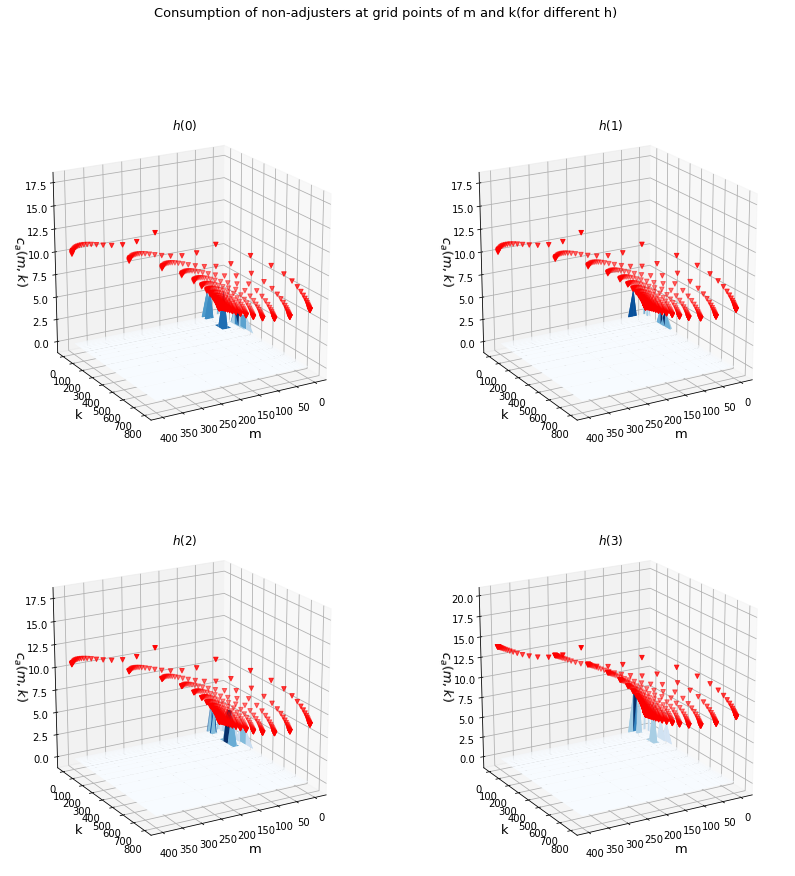

In [24]:
## 3D scatter plots of consumption function 
##    at all grids and grids after dct for both adjusters and non-adjusters


## for non-adjusters

## full grids 
#mmgrid,kkgrid = np.meshgrid(mgrid,kgrid)

### for adjusters 
fig = plt.figure(figsize=(14,14))
fig.suptitle('Consumption of non-adjusters at grid points of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## prepare the reduced grids 
    hgrid_fix=hgrid_id
    
    
    ## for each h grid, take the 95% mass of m and k as the maximum of the m and k axis 
    
    marginal_mk = joint_distr[:,:,hgrid_fix]
    marginal_m = marginal_mk.sum(axis=0)
    marginal_k = marginal_mk.sum(axis=1)
    mmax = mgrid[(np.abs(marginal_m.cumsum()-mass_pct*marginal_m.cumsum().max())).argmin()]
    kmax = kgrid[(np.abs(marginal_k.cumsum()-mass_pct*marginal_k.cumsum().max())).argmin()]

    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.plot_surface(mmgrid,kkgrid,c_n_rdc,cmap='Blues',
                    label='StE(after dct):non-adjuster')
    ax.scatter(mmgrid,kkgrid,cn_StE[:,:,hgrid_fix],marker='v',color='red',
               label='StE(before dct): non-adjuster')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    ax.set_zlabel(r'$c_a(m,k)$',fontsize=13)
    #ax.set_xlim([0,mmax])
    #ax.set_ylim([0,kmax])
    ax.set_title(r'$h({})$'.format(hgrid_fix))
    ax.view_init(20, 60)

##### Observation

- For a given grid value of productivity, the remaining grid points after DCT to represent the whole consumption function are concentrated in low values of $k$ and $m$. This is because the slopes of the surfaces of marginal utility are changing the most in these regions.  For larger values of $k$ and $m$ the functions become smooth and only slightly concave, so they can be represented by many fewer points
- For different grid values of productivity (2 sub plots), the numbers of grid points in the DCT operation differ. From the lowest to highest values of productivity, there are 78, 33, 25 and 18 grid points, respectively. They add up to the total number of gridpoints of 154 after DCT operation, as we noted above for marginal utility function. 

#### Distribution of states 

- We first plot the distribution of $k$ fixing $m$ and $h$. Next, we plot the joint distribution of $m$ and $k$ only fixing $h$ in 3-dimenstional space.  
- The joint-distribution can be represented by marginal distributions of $m$, $k$ and $h$ and a copula that describes the correlation between the three states. The former is straightfoward. We plot the copula only. The copula is essentially a multivariate cummulative distribution function where each marginal is uniform. (Translation from the uniform to the appropriate nonuniform distribution is handled at a separate stage).


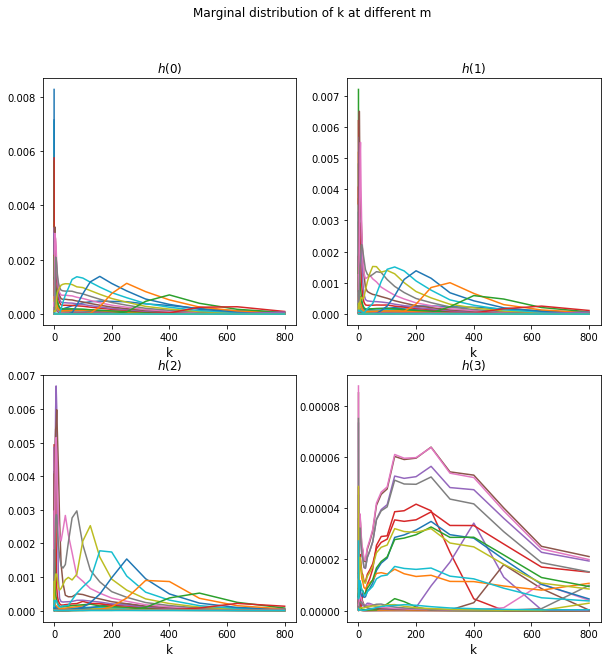

In [16]:
### Marginalize along h grids

joint_distr =  EX3SS['joint_distr']
joint_distr_km = EX3SS['joint_distr'].sum(axis=2)

### Plot distributions in 2 dimensional graph 

fig = plt.figure(figsize=(10,10))
plt.suptitle('Marginal distribution of k at different m')

for hgrid_id in range(EX3SS['mpar']['nh']):
    ax = plt.subplot(2,2,hgrid_id+1)
    ax.set_title(r'$h({})$'.format(hgrid_id))
    ax.set_xlabel('k',size=12)
    for id in range(EX3SS['mpar']['nm']):   
        ax.plot(kgrid,joint_distr[id,:,hgrid_id])

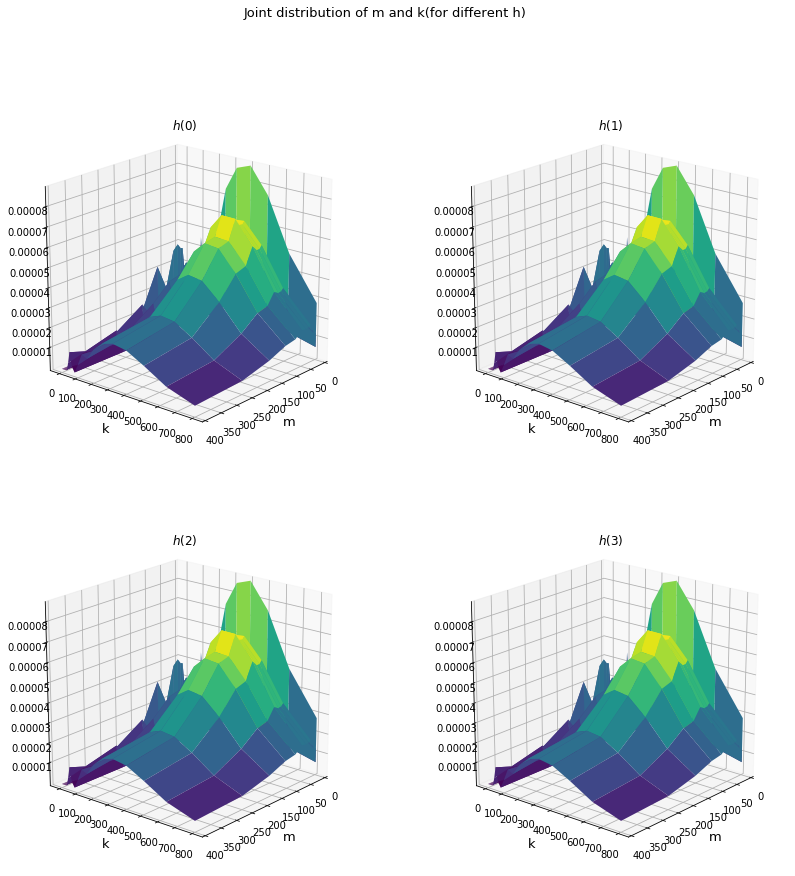

In [17]:
## Plot joint distribution of k and m in 3d graph

fig = plt.figure(figsize=(14,14))
fig.suptitle('Joint distribution of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.plot_surface(mmgrid,kkgrid,joint_distr[:,:,hgrid_fix], rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    #ax.set_zlabel(r'$p(m,k)$',fontsize=10)
    ax.set_title(r'$h({})$'.format(hgrid_id))
    ax.set_xlim(0,400)
    ax.view_init(20, 40)

Notice the CDFs in StE copula have 4 modes, corresponding to the number of $h$ gridpoints. Each of the four parts of the cdf is a joint-distribution of $m$ and $k$.  It can be presented in 3-dimensional graph as below.  

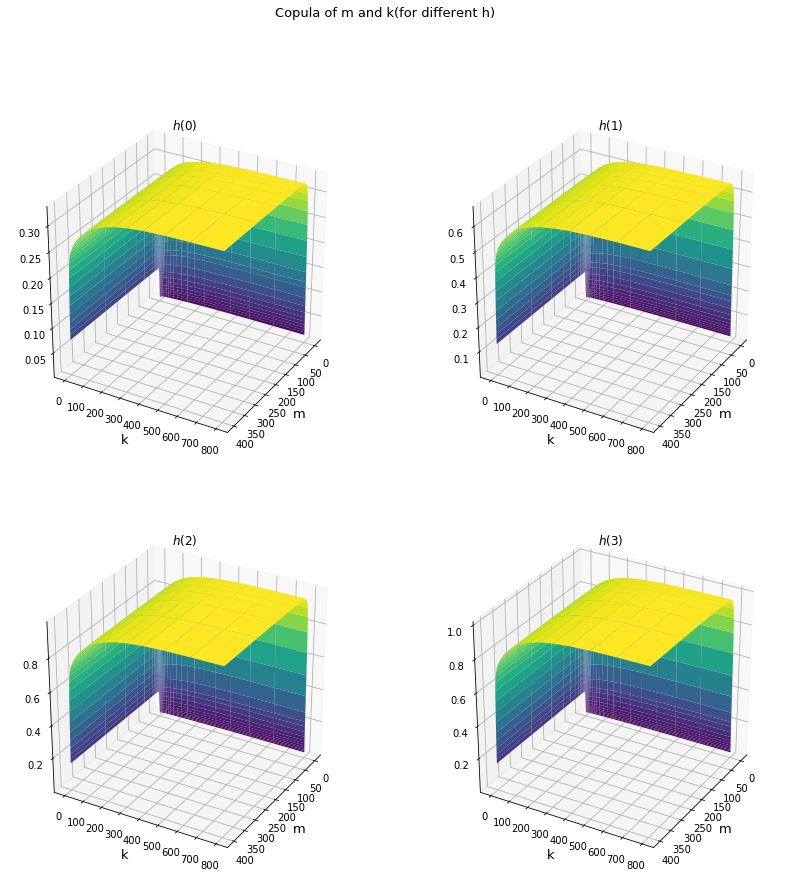

In [18]:
## Plot the copula 

cdf=EX3SS['Copula']['value'].reshape(4,30,30)   # important: 4,30,30 not 30,30,4? 

fig = plt.figure(figsize=(14,14))
fig.suptitle('Copula of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.plot_surface(mmgrid,kkgrid,cdf[hgrid_id,:,:], rstride=1, cstride=1,
                    cmap='viridis', edgecolor='None')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    ax.set_title(r'$h({})$'.format(hgrid_id))
    
    ## for each h grid, take the 95% mass of m and k as the maximum of the m and k axis 
    
    marginal_mk = joint_distr[:,:,hgrid_id]
    marginal_m = marginal_mk.sum(axis=0)
    marginal_k = marginal_mk.sum(axis=1)
    mmax = mgrid[(np.abs(marginal_m.cumsum()-mass_pct*marginal_m.cumsum().max())).argmin()]
    kmax = kgrid[(np.abs(marginal_k.cumsum()-mass_pct*marginal_k.cumsum().max())).argmin()]
    
    #ax.set_xlim(0,mmax)
    #ax.set_ylim(0,kmax)
    ax.view_init(30, 30)

Given the assumption that the copula remains the same after aggregate risk is introduced, we can use the same copula and the marginal distributions to recover the full joint-distribution of the states.  

### Summary: what do we achieve after the transformation?

- Using the DCT, the dimension of the policy and value functions are reduced from 3600 to 154 and 94, respectively.
- By marginalizing the joint distribution with the fixed copula assumption, the marginal distribution is of dimension 64 compared to its joint distribution of a dimension of 3600.


